# Define spectrum

In [1]:
###########
#Usual libraries
###########
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from matplotlib import dates
import math
import netCDF4 as NC4
import os
import datetime
from scipy.signal import detrend,welch
import numpy.matlib
from numpy.fft import ifft2
from numpy import squeeze
import xarray as xr    # only used for filters: this dependency should be removed
from scipy.interpolate import griddata
from matplotlib.colors import Normalize
from scipy.optimize import fminbound, fsolve
###########
#Additionals functions
###########
from scipy.io import loadmat
from scipy.stats.distributions import chi2
from scipy.interpolate import LinearNDInterpolator

###########
#Wave physics and simulation functions
###########

from surface_simulation_functions import *
from wave_physics_functions import *



import warnings

warnings.filterwarnings("ignore")

mpl.rcParams.update({'figure.figsize':[10,6],'font.size': 14,'savefig.facecolor':'white'})

## Get 2D (frequency,direction) spectrum from buoy 'first 5' moments data

In [2]:
path_buoy='./'
# file_buoy='CDIP46258_201604_spectrum.nc'
file_buoy='CDIP46214_2023_avg1h.nc'

# file_buoy='CDIP51201_IG2012_avg3h.nc'

# it=103 # choice of time index ... 
# it=351 # choice of time index 

# ################# Reads all the variables we need from the NetCDF file
nc_buoy=NC4.Dataset(os.path.join(path_buoy+file_buoy))
print("Variables disponibles :")
for var_name in nc_buoy.variables:
    print(var_name)
    
lat=nc_buoy.variables['latitude'][:,0]
lon=nc_buoy.variables['longitude'][:,0]


fb=nc_buoy.variables['frequency'][:]
timeb=nc_buoy.variables['time'][:]
ntimeb=len(timeb)

f2b=nc_buoy.variables['frequency2'][:]
f1b=nc_buoy.variables['frequency1'][:]


th1mb=nc_buoy.variables['th1m'][:,0,:]
sth1mb=nc_buoy.variables['sth1m'][:,0,:]
th2mb=nc_buoy.variables['th2m'][:,0,:]
sth2mb=nc_buoy.variables['sth2m'][:,0,:]
freqb=(f1b+f2b)/2.
dfb=f2b-f1b
Efb=nc_buoy.variables['ef'][:,0,:]



df2b=np.tile(dfb.T,(ntimeb,1))
print('For your information this is the shape of the df2b array:',np.shape(df2b))
print('Shape of Efb',np.shape(Efb))
ifmaxb=len(fb)-1
# computes surface elevation variance
E=(np.sum(Efb[:,0:ifmaxb]*df2b[:,0:ifmaxb],axis=1))


d2r=np.pi/180# deg. to radians conversion factor


Variables disponibles :
time
station
string16
station_name
longitude
latitude
frequency
frequency1
frequency2
ef
th1m
sth1m
th2m
sth2m
For your information this is the shape of the df2b array: (25211, 64)
Shape of Efb (25211, 64)


In [3]:
print(Efb)

[[4.798557758331299 20.350364685058594 48.787071228027344 ...
  4.14069128036499 9.015487670898438 3.2264561653137207]
 [-- -- -- ... -- -- --]
 [0.08327732980251312 0.052778277546167374 -- ... -- --
  0.013618890196084976]
 ...
 [0.028185952454805374 0.05875488743185997 0.1258464902639389 ...
  0.0038453196175396442 0.0032668488565832376 0.0036223807837814093]
 [0.01520176138728857 0.030652109533548355 0.05935736373066902 ...
  0.006174955051392317 0.0045491480268538 0.004696235526353121]
 [0.0177424568682909 0.04921497404575348 0.11343172937631607 ...
  0.005740817170590162 0.00585326598957181 0.004558802116662264]]


In [4]:
# Repris du TD " Waves1_lab2_buoy_and_altimeter"

def buoy_spectrum2d(a0,a1,a2,b1,b2, ndirs):

    nfreq = np.size(a0)
    dr=np.pi/180
    dtheta=360/ndirs
    dirs=np.arange(0.,ndirs,1.)*dtheta
    #print(nfreq,ndirs,np.size(dirs),dirs)
    
    c1 = a1+1j*b1
    c2 = a2+1j*b2
    p1 = (c1-c2*np.conj(c1))/(1.-abs(c1)**2)
    p2 = c2-c1*p1
    
    # numerator(2D) : x
    x = 1.-p1*np.conj(c1)-p2*np.conj(c2)
    x = numpy.tile(numpy.real(x),(ndirs,1)).T
    
    # denominator(2D): y
    a = dirs*dr
    e1 = numpy.tile(numpy.cos(a)-1j*numpy.sin(a),(nfreq,1))
    e2 = numpy.tile(numpy.cos(2*a)-1j*numpy.sin(2*a),(nfreq,1))
    
    p1e1 = numpy.tile(p1,(ndirs,1)).T*e1
    p2e2 = numpy.tile(p2,(ndirs,1)).T*e2
    
    y = abs(1-p1e1-p2e2)**2
    
    D = x/(y)
    
    # normalizes the spreading function,
    # so that int D(theta,f) dtheta = 1 for each f  
    tot = numpy.tile(numpy.sum(D, axis=1),(ndirs,1)).T
    D = D/tot
    
    sp2d = numpy.tile(a0,(ndirs,1)).T*D/(dr*dtheta)
    
    return sp2d,D,dirs

2023-04-27T22:39:00.000000000 1 seconds
range of time values for buoy  11713.875  to 12763.458333333489 . Time of sentinel 2: 12169.94375
The E(f) spectrum has  64 frequencies.
For your information this is the shape of the Efth array: (64, 72)
Array: (64,)
Checking that the Hs is correct for Efth: 1.308064834980133


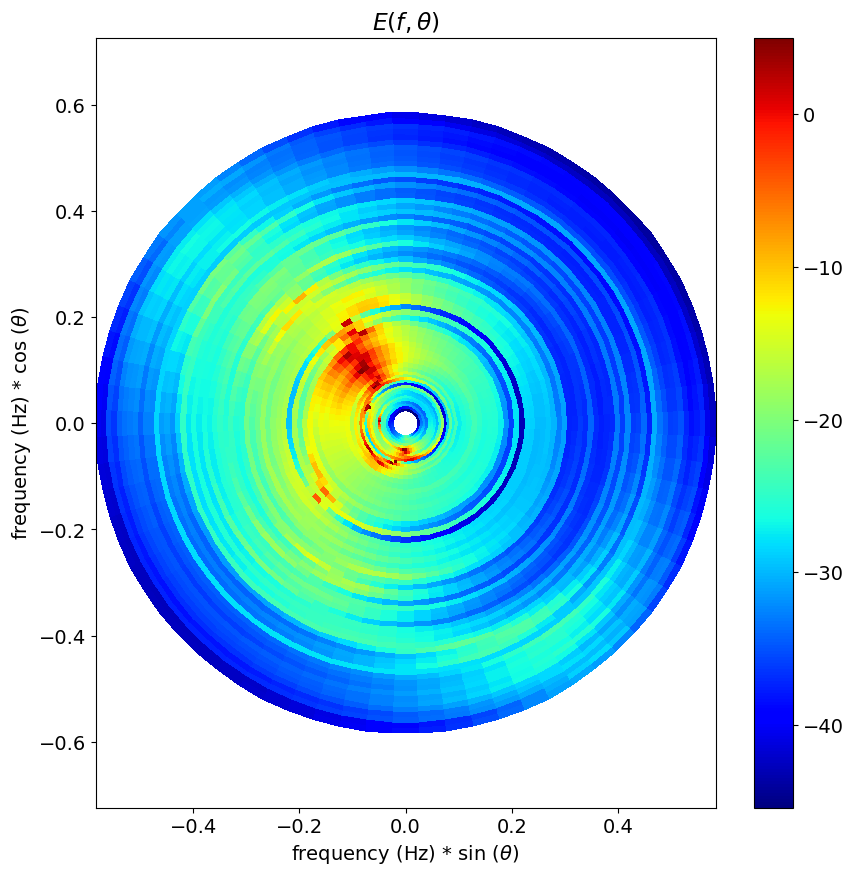

In [5]:
# Choix du pas de temps

t1=np.datetime64('2023-04-27 22:39', 'ns')
# t1=np.datetime64('2016-04-29 18:40', 'ns')

t0=np.datetime64('1990-01-01 00:00', 'ns')
print(t1,np.timedelta64(1, 's'))

tdiff=(t1-t0);
tds = tdiff / np.timedelta64(1, 's')/86400
print('range of time values for buoy ',nc_buoy.variables['time'][0],' to',nc_buoy.variables['time'][-1],'. Time of sentinel 2:',tds)
# Now finds indices of points that are less than 6 hours from the S2 image
indt=np.where(nc_buoy.variables['time'] > tds  )[0]
it=indt[0]

# it=103 # choice of time index ... 
# it=351 # choice of time index ... 

# La suite

a0=Efb[it,:]
print('The E(f) spectrum has ',np.size(a0),'frequencies.')
# print('Hs: ',Hsb[it],' m.')
m1=abs(1.-0.5*(sth1mb[it,:]*d2r)**2)
m2=abs(1.-2*(sth2mb[it,:]*d2r)**2)

a1=np.cos(th1mb[it,:]*d2r)*m1 # Directional distribution 2*pi periodic component (cosine component)
b1=np.sin(th1mb[it,:]*d2r)*m1 # Directional distribution 2*pi periodic component (sine component)
a2=np.cos(2*th2mb[it,:]*d2r)*m2 # Directional distribution pi periodic component (cosine component)
b2=np.sin(2*th2mb[it,:]*d2r)*m2 # Directional distribution pi periodic component (sine component)

ndirs=36*2
dth=np.pi*2/ndirs
nfreq = np.size(a0)
[Efth,D,dirs] = buoy_spectrum2d(a0,a1,a2,b1,b2,ndirs) #Here the MEM method that estimate the 2D spectrum from the first 5 Fourier Parameters
print('For your information this is the shape of the Efth array:',np.shape(Efth))

f2D=np.tile(freqb,(ndirs,1)).T
xf=f2D*np.tile(np.cos(dirs*d2r).T,(nfreq,1))
yf=f2D*np.tile(np.sin(dirs*d2r).T,(nfreq,1))
F,DIRS=np.meshgrid(freqb,dirs)

# Checking on spectrum normalization:
print('Array:',np.shape(np.sum(Efth,axis=1)*dth))
Hsfrom2D=4*np.sqrt(np.sum(np.sum(Efth,axis=1)*dth*dfb))
print('Checking that the Hs is correct for Efth:',Hsfrom2D)

#########################################################################
## Plot directionnal wave spectrum                              #########
## WARNING: Here the direction convention is "Nautical, from"   #########
#########################################################################
plt.figure(4,figsize=(10,10))
plt.pcolormesh(yf.T,xf.T,10*np.log10(Efth.T),shading='auto',vmax=5,cmap='jet');
plt.title(r'$E(f,\theta)$');
plt.xlabel(r'frequency (Hz) * sin ($\theta$)');
plt.ylabel(r'frequency (Hz) * cos ($\theta$)');
plt.axis('equal')
plt.colorbar();

## S2 simulation

In [6]:
import xarray as xr    # only used for filters: this dependency should be removed
from scipy.interpolate import griddata


######################  
# [Ekxky,kx,ky,kx2,ky2] = wavespec_Efth_to_Ekxky(eft1s,fren,dfreq,dirn,dth,dkx=0.0001,dky=0.0001,nkx=250,nky=250,doublesided=0) 
def  wavespec_Efth_to_Ekxky(eft1s,fren,dfreq,dirn,dth,depth=3000.,dkx=0.0001,dky=0.0001,nkx=250,nky=250,doublesided=1,verbose=0,doplot=0,trackangle=0)  :
    '''
    Converts E(f,theta) spectrum from buoy or model to E(kx,ky) spectrum similar to image spectrum
    2023/11/14: preliminary version, assumes dfreq is symmetric (not eaxctly true with WW3 output and waverider data) 
    inputs :
            - etfs1 : spectrum
    output : 
            - Ekxky: spectrum
            - kx: wavenumber in cycles / m  
    '''
    [nf,nt]=np.shape(eft1s)
    tpi=2*np.pi
    grav=9.81

# makes a double sided spectrum
    if doublesided == 1:
        eftn=0.5*(eft1s+np.roll(eft1s,nt//2,axis=1))
    else: 
        eftn=eft1s
    Hs1 = 4*np.sqrt(np.sum(np.sum(eftn,axis=1)* dfreq)*dth)
# wraps around directions
    dlast=dirn[0]+360.
    dirm=np.concatenate([dirn,[dlast]])
    elast=eftn[:,0]
    eftm1=np.concatenate([eftn.T,[elast]]).T
# adds zero energy in a low frequency to avoid interpolation across k=0
    ffirst=fren[0]-0.9*(fren[1]-fren[0])
    frem=np.concatenate([[ffirst],fren])
    efirst=eftm1[0,:]*0
    eftm=np.concatenate([[efirst],eftm1])

#plt.pcolormesh(fren, dirm, np.log10(eftm).T)
    km=(2*np.pi*frem)**2/(grav*2*np.pi)   # cycles / meter
    for ii in range(nf):
       km[ii]=k_from_f(frem[ii],D=depth)/(2*np.pi)            # finite water depth
    km2=np.tile(km.reshape(nf+1,1),(1,nt+1))

# eftn*df*dth = Ek*k*dk*dth -> Ek = efth *df /(k * dk)  =  efth *Cg /k
    Cg2=np.sqrt(grav/(km2*tpi))*0.5
    Jac=Cg2/km2
    dirm2=np.tile(dirm.T,(nf+1,1))*np.pi/180.
    kxn=km2*np.cos(dirm2+trackangle)
    kyn=km2*np.sin(dirm2+trackangle)
    #plt.scatter(kxn,kyn,  marker='.', s = 20)
    kx=np.linspace(-nkx*dkx,(nkx-1)*dkx,nkx*2)
    ky=np.linspace(-nky*dky,(nky-1)*dky,nky*2)
    kx2, ky2 = np.meshgrid(kx,ky,indexing='ij')   #should we transpose kx2 and ky2 ???
    Ekxky = griddata((kxn.flatten(), kyn.flatten()), (eftm*Jac).flatten(), (kx2, ky2), method='nearest')
    Hs2=4*np.sqrt(np.sum(np.sum(Ekxky))*dkx*dky)
# make sure energy is exactly conserved (assuming kmax is consistent with fmax
    print('Hs1,Hs2:',Hs1,Hs2)
    Ekxky = Ekxky * (Hs1/Hs2)**2
    return Ekxky,kx,ky,kx2,ky2


def k_from_f(f,D=10000.,g=9.81):
    # inverts the linear dispersion relation (2*pi*f)^2=g*k*tanh(k*dep) to get 
    #k from f and dep. 2 Arguments: f and dep. 
    eps=0.000001
    sig=np.array(2*np.pi*f)
    if D > 1000.:
        # print("Deep water approximation")
        k=sig**2/g
    else:
        Y=D*sig**2/g
        X=np.sqrt(Y)
        I=1
        F=1.
        while (abs(np.max(F)) > eps):
            H=np.tanh(X)
            F=Y-(X*H)
            FD=-H-(X/(np.cosh(X)**2))
            X=X-(F/FD)

        k=X/D

    return k # wavenumber

###############################################################################################################################
def S2_simu(Efth,freq,df,dir2,dth,fac,facr,na,nt,ntime,dti,plotb,dx=10.,nx=800,iseed=0,U10=6,Udir=40,Ux=-1,Uy=0,betad=9.06,thetad=6.24 ):
    
#   dx is pixel size       (NB: dy=dx)
#   nx is number of pixels (NB: nx=ny)
#   fac is the mean image value  
#   facr is the reflection coefficient used to impose reflections: if zero, full 2D spectrum is used
#   na: additive noise parameter
#   nt: multiplicative noise parameter
#   ntime: number of images 
#  dti: time step between images

    # Define constant
    d2r=np.pi/180
    nxp=(nx-1)/8+1
    nxp=int(nxp)

    print('nxp',nxp)
    
    dy=dx
    ny=nx

    # Defines wind and current vectors (parameters of the function in future version)
    Udir=Udir*d2r # direction to, trig. convention


    #Defines sun and sensor angles (should change with the different times)
    beta = betad * d2r
    thetav = thetad * d2r
    
    # Angles d'azimut trigonométriques: this should be a parameter passed to the function ... 
    phitrig = [148.1901, 148.8061, 149.1342, 149.4561]
    
    # Azimut de la pente spéculaire
    phip = phitrig[1] * d2r


    #-----------------------------------------------------
    # Computes maps of the surface elevation
    #-----------------------------------------------------

    # surface size
    nkx=nx*2   # Takes a bigger surface to avoid periodic funny boundary effects ... 
    nky=nx*2

    dkx = 2 * np.pi / (dx * nkx)
    dky = 2*np.pi/(dy*nky)

    kX0 = np.fft.fftshift(np.fft.fftfreq(nkx,d=dx))*2*np.pi
    kY0 = np.fft.fftshift(np.fft.fftfreq(nky,d=dy))*2*np.pi


    kX,kY = np.meshgrid(kX0,kY0)# , indexing='ij')
    kK = (np.sqrt(kX**2+kY**2))
    kPhi = np.arctan2(kY,kX)*180/np.pi
    kF = kK
    kPhi[kPhi<0]=kPhi[kPhi<0]+360

    # create a dataArray with the new (i.e. wanted) values of F written in a cartesian array
    kF2 = xr.DataArray(kF, coords=[("ky", kY0), ("kx",kX0)])

    kPhi2 = xr.DataArray(kPhi, coords=[("ky", kY0), ("kx",kX0)])
    FPhi2s = xr.Dataset(
    {'kF': kF2,
    'kPhi': kPhi2}
    ).stack(flattened=["ky", "kx"])

    print('nkx:',nkx,nky) 
    Ekxky,kx,ky,kx2T,ky2T = wavespec_Efth_to_Ekxky(Efth,freq,dfb,dir2,dth,dkx=dkx/(2*np.pi),dky=dky/(2*np.pi),nkx=nkx,nky=nky,doublesided=0) 

    kx2=kx2T.T
    ky2=ky2T.T 
    Ekxky_for_surf=Ekxky/(2*np.pi)**2
    Etot=np.sum(Ekxky_for_surf.flatten())*dkx*dky
    # compared to eq. 16 in De Carlo et al. (2023) the factor 0.5 corrects for single sided spec
    Qkk=np.sqrt(np.sum(Ekxky_for_surf.flatten()**2)*dkx*dky*0.5)/Etot

# computes Hs and Qkk
    Hskk=4*np.sqrt(Etot)
    print('Testing Hs:',Hskk,np.shape(Ekxky),nkx,nky) 

    plt.figure(1)
    plt.get_cmap('viridis')  # Utilisez 'gray' pour la carte de couleurs
    plt.title('Wave spectrum interpolated in kx,ky plane')
    plt.clf()  # Equivalent à 'clf'
    
    # Plotting convention is direction from
    pfac=1000
    plt.pcolor(kx2*pfac, ky2*pfac, 10 * np.log10(Ekxky_for_surf))   #, shading='flat')
    plt.colorbar()  # Ajouter une barre de couleur

    
    # Utiliser une alternative à `set_renderer` pour le rendu 'painters'
    fig = plt.gcf()  # Obtenez la figure actuelle
    fig.set_dpi(150)  # Réglage de la résolution
    fig.set_size_inches(3, 3)  # Ajuster la taille de la figure
    
    for i in range(1, 8):
        plt.plot(10 * i * np.cos(np.linspace(0, 2 * np.pi, 49)), 10 * i * np.sin(np.linspace(0, 2 * np.pi, 49)), 'k-', linewidth=1)
    
    # Ajouter les lignes de référence
    plt.plot([-60, 60], [0, 0], 'k-', linewidth=1)
    plt.plot([0, 0], [-60, 60], 'k-', linewidth=1)
        
    # Ajuster les axes
    plt.axis('equal')
    plt.axis([-50, 50, -50, 50])
    plt.xlabel('k_x / 2 \pi (counts per km)')
     # plt.caxis([20, 70])
        
    plt.show()
        
    Efths = np.roll(Efth, shift=36, axis=1)  # Equivalent à circshift avec [0 36]

    Hspec = 4 * Efth * Efths / ((Efth + Efths)**2)
        

    # -------------------------Random draw of phases....
    phases = np.random.rand(nky*2, nkx*2) * 2 * np.pi   # WARNING: is this ny,nx or nx,ny ? 
    i1=nkx//2
    i2=i1+nkx
  

    rng = np.random.default_rng(iseed)
    rg = rng.uniform(low=0.0, high=1.0, size=(nky*2,nkx*2))
    zhats=np.fft.ifftshift(np.sqrt(2*Ekxky_for_surf*dkx*dky)*np.exp(1j*2*np.pi*rg))
    kx2D=np.fft.ifftshift(ky2) 
    ky2D=np.fft.ifftshift(kx2) 
    #print('kx2D',kx2D)

             
    kN=np.sqrt(kx2D**2+ky2D**2)
    grav=9.81
    
    si2s=np.sqrt(grav*kN*2*np.pi) 
    
    # plt.figure
    
    # plt.plot(si2s[0,:],abs(zhats[0,:]),c='k')
    # #plt.plot(ky2D[:,0],abs(zhats[:,0]),c='r')
    # #plt.plot(ky2D[0,:],abs(zhats[0,:]),c='m')
    # #plt.plot(kx2D[:,0],abs(zhats[:,0]),c='b')
    # plt.xlim([-0.8,0.8])

    
    xp = np.linspace(0, dx * nxp, nxp)
    x2 = np.tile(xp, (nxp, 1))
    y2 = np.tile(xp.reshape(-1, 1), (1, nxp))
    yp = xp

    #----------------------------- temps d'évaluation de la surface pour movie 

    t = np.linspace(0, (ntime - 1) * dti, ntime)

    # Set colormap to gray
    plt.set_cmap("viridis")    
    # Create a figure
    nfig = 30
    plt.figure(nfig, figsize=(3 * nxp / 100, 3 * nxp / 100))
    plt.clf()
    
    
    # Initialize variables
    allB = np.zeros((nx, nx, ntime))
    allz = np.zeros((nx, nx, ntime))
    mssx = 0.001 + 0.00316 * U10
    mssy = 0.003 + 0.00185 * U10
    mss = mssx + mssy
    sx0 = -np.tan(beta) * np.sin(phip)  # slope without long wave effect
    sy0 = -np.tan(beta) * np.cos(phip)


    allind = (nx * 2) * 10 + 10 + np.arange(1, nx ** 2 + 1)
    for ii in range(1, nx - 1):
        allind[ii * nx:] += nx
    
    choppy = 0 


    for i in range(ntime):
        # Crée ou récupère l'image de la trame
        # Exemple : Créer une trame vide
        frame = np.zeros((ny, nx, 3), dtype=np.uint8)

    ######### Loop on the time #########
    tpi=2*np.pi   # this factor is needed because the kx2,ky2 are in cycles / m not in rad/m
    for ii in range(ntime):
    
        t1 = t[ii]
        #phasor = np.exp(-1j * (si2s - (kx2*tpi) * Ux - (ky2*tpi) * Uy) * t1)
        phasor = np.exp(-1j * (si2s -( kx2D*tpi*Ux + ky2D*tpi*Uy)) * t1)
        # Compute zeta1
        inds=np.where(np.abs(zhats[0,:]) > 0.01)[0]
        # print('ii:',ii,t1,inds,'##',si2s[0,inds]*t1,np.real(np.exp(-1j*si2s[0,inds]*t1)) )
        
        zeta1= np.real(np.fft.ifft2(zhats*phasor,norm="forward"))
        print('phasor:',np.real(phasor[0,inds]),'##',np.real(zhats[0,inds]*phasor[0,inds]))
        
        # print('time=',t1,', checking Hs: 4*std of zeta1:',4*np.std(zeta1.flatten()))
# CHOPPY NOT WORKING NOW ... 
        if choppy == 1:
            Dx = np.real(ifft2(zhats * 1j * kx2s * phasor / kns)) * (nkx**2) / dx
            Dy = np.real(ifft2(zhats * 1j * ky2s * phasor / kns)) * (nkx**2) / dx
            
            iDx = np.floor(Dx).astype(int)
            iDy = np.floor(Dy).astype(int)
            wDx = Dx - iDx
            wDy = Dy - iDy
        
            zetachoppy = (
                (1 - wDx[allind]) * (
                    zeta1[allind + iDx[allind] * (nx * 2) + iDy[allind]] * (1 - wDy[allind]) +
                    zeta1[allind + iDx[allind] * (nx * 2) + iDy[allind] + 1] * wDy[allind]
                )
                + wDx[allind] * (
                    zeta1[allind + (iDx[allind] + 1) * (nx * 2) + iDy[allind]] * (1 - wDy[allind]) +
                    zeta1[allind + (iDx[allind] + 1) * (nx * 2) + iDy[allind] + 1] * wDy[allind]
                )
            )

            zeta = zetachoppy
        else:
            zeta = zeta1[:nky:2, :nkx:2]
        
        # Slope computation
        
        sx1 = np.real(np.fft.ifft2(zhats * (1j*tpi) * kx2D *phasor,norm="forward"))
        sy1 = np.real(np.fft.ifft2(zhats * (1j*tpi) * ky2D *phasor,norm="forward"))
        
        sx = sx1[:nky:2, :nkx:2]
        sy = sy1[:nky:2, :nkx:2]
        print('dx,dy:',dx,dy)
        dx2=dx/2
        dy2=dy/2
        x=np.linspace(0,dx*(nx-1),nx)
        y=np.linspace(0,dy*(ny-1),ny)

        
        # Adds slope of bistatic look direction + rotate in wind direction
        sxt = (sx + sx0) * np.cos(Udir) + (sy + sy0) * np.sin(Udir)
        syt = (sy + sy0) * np.cos(Udir) - (sx + sx0) * np.sin(Udir)
        sx0t = sx0 * np.cos(Udir) + sy0 * np.sin(Udir)
        sy0t = sy0 * np.cos(Udir) - sx0 * np.sin(Udir)
        
        # Backscatter coefficient computation
        norma = (2 * np.pi * np.sqrt(mssx * mssy))
        B = np.exp(-0.5 * (sxt**2 / mssx + syt**2 / mssy)) / (np.cos(beta)**4 * np.cos(thetav))
        B0 = np.exp(-0.5 * (sx0t**2 / mssx + sy0t**2 / mssy))


        # Store results
        allz[:, :, ii] = zeta
        allB[:, :, ii] = B / B0

        print('B0',B0)
        print('shape zeta',np.shape(zeta))
        print('shape B',np.shape(B))
        
        allB[:, :, ii] = zeta
    
        #something to check on
        if ii==0:
            np.mean(np.std(B))/np.mean(np.mean(B))
        
        if plotb == 1 and ii == 0:
            # Plot zeta
            # print('x', np.shape(x))
            # print('zeta[:,0]', np.shape(zeta[:, 0]))
            # print('zeta[10:nx+10,10]', np.shape(zeta1[10:nx+10, 10]))
            
            plt.figure(101)
            plt.plot(x, zeta[:, 0], 'k-', x, zeta1[10:nx+10, 10], 'r-')
            
            # Image zeta
            plt.figure(nfig)
            plt.clf()  # Nettoyer la figure précédente
            plt.gcf().set_size_inches((1 * nxp + 300) / 100, (1 * nxp + 200) / 100)  # Diviser par 100 pour convertir en pouces 
            # Afficher zeta
            img = plt.imshow(
                np.fliplr(zeta[:nxp, :nxp]).T, 
                extent=[0, 1000, 0, 1000], 
                vmin=-1, vmax=1, 
                cmap='viridis'
            )
            
            plt.colorbar(img)
            
            # Configurer les axes
            plt.axis([0, 1000, 0, 1000])
            plt.xlabel('x (m)')
            plt.ylabel('y (m)')
            

        if plotb == 1:
            # Plots B
            plt.figure(nfig + 2)
            plt.clf()
            plt.imshow(np.fliplr(B[:nxp, :nxp] / B0).T, extent=[0, 1000, 0, 1000], cmap=plt.get_cmap('gray'))
            
            plt.colorbar()
            plt.axis('equal')
            plt.axis([0, 1000, 0, 1000])
            plt.xlabel('x (m)')
            plt.ylabel('y (m)')
            plt.gcf().set_size_inches((1 * nxp + 300) / 100, (1 * nxp + 200) / 100)  # Diviser par 100 pour convertir en pouces
            
    
    ind1, ind2, ind3, ind4 = 0, 2, 3, 4  
    # print('ind:',ind1,ind4)
    # Generate images based on backscatter coefficient and noise
    img1 = np.round((nt * np.random.rand(nx, nx) + 1 - nt / 2) * fac * (squeeze(allB[:, :, ind1]) * (1 - na / 2) + na * np.random.rand(nx, nx)))
    img2 = np.round((nt * np.random.rand(nx, nx) + 1 - nt / 2) * fac * (squeeze(allB[:, :, ind2]) * (1 - na / 2) + na * np.random.rand(nx, nx)))
    img3 = np.round((nt * np.random.rand(nx, nx) + 1 - nt / 2) * fac * (squeeze(allB[:, :, ind3]) * (1 - na / 2) + na * np.random.rand(nx, nx)))
    img4 = np.round((nt * np.random.rand(nx, nx) + 1 - nt / 2) * fac * (squeeze(allB[:, :, ind4]) * (1 - na / 2) + na * np.random.rand(nx, nx)))
        
    # Image times
    imgtimes = t[[ind1, ind2, ind3, ind4]] - t[ind1]

    return img1, img2, img3, img4, imgtimes, phitrig, nx,ny,x,y,dx,dy

### Test de la fonction S2_simu

nxp 101
nkx: 1602 1602
Hs1,Hs2: 1.308064834980133 1.305917181620613
Testing Hs: 1.3080648349801345 (3204, 3204) 1602 1602


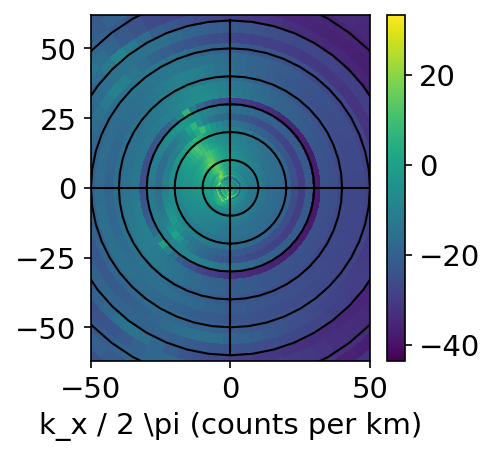

phasor: [] ## []
dx,dy: 10 10
B0 0.40842036588294556
shape zeta (801, 801)
shape B (801, 801)
phasor: [] ## []
dx,dy: 10 10
B0 0.40842036588294556
shape zeta (801, 801)
shape B (801, 801)
phasor: [] ## []
dx,dy: 10 10
B0 0.40842036588294556
shape zeta (801, 801)
shape B (801, 801)
phasor: [] ## []
dx,dy: 10 10
B0 0.40842036588294556
shape zeta (801, 801)
shape B (801, 801)
phasor: [] ## []
dx,dy: 10 10
B0 0.40842036588294556
shape zeta (801, 801)
shape B (801, 801)


<Figure size 1000x600 with 0 Axes>

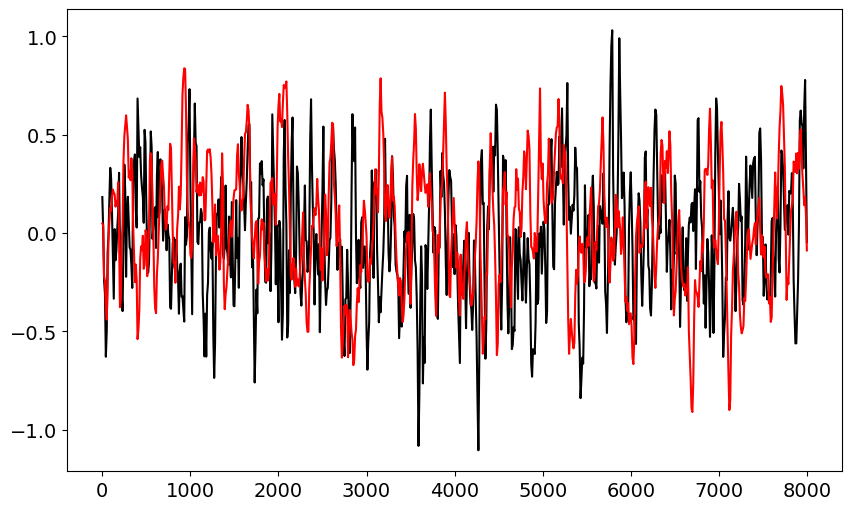

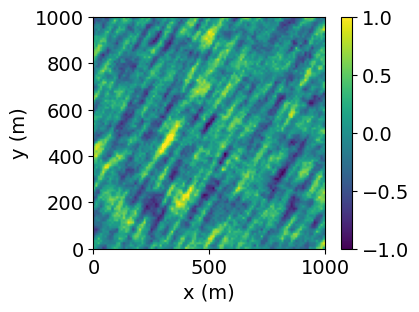

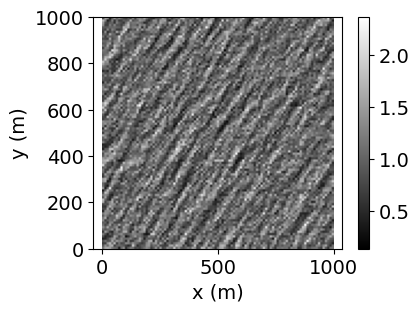

In [7]:
#def S2_simu(Efth,freq,df,dir2,dth,fac,facr,na,nt,ntime,dti,plotb,dx=10.,nx=800,iseed=0,U10=6,Udir=40,Ux=-1,Uy=0,betad=9.06,thetad=6.24 ):

#[img1, img2, img3, img4, imgtimes, phitrig, nx, ny, x, y, dx, dy  ]=S2_simu(Efth,fb,dfb,dirs,dth ,1000,0.  ,0.,0.15,5,1.25,1,dx=10,nx=400,iseed=0);
[img1, img2, img3, img4, imgtimes, phitrig, nx, ny, x, y, dx, dy  ]=S2_simu(Efth,fb,dfb,dirs,dth ,1000,0.  ,0.,0,5,1,1,dx=10,nx=801,iseed=0,U10=6,Udir=40,Ux=-1,Uy=0,betad=9.06,thetad=6.24);
# print(imgtimes)
# print('Ux=',Ux)
# print('Uy=',Uy)

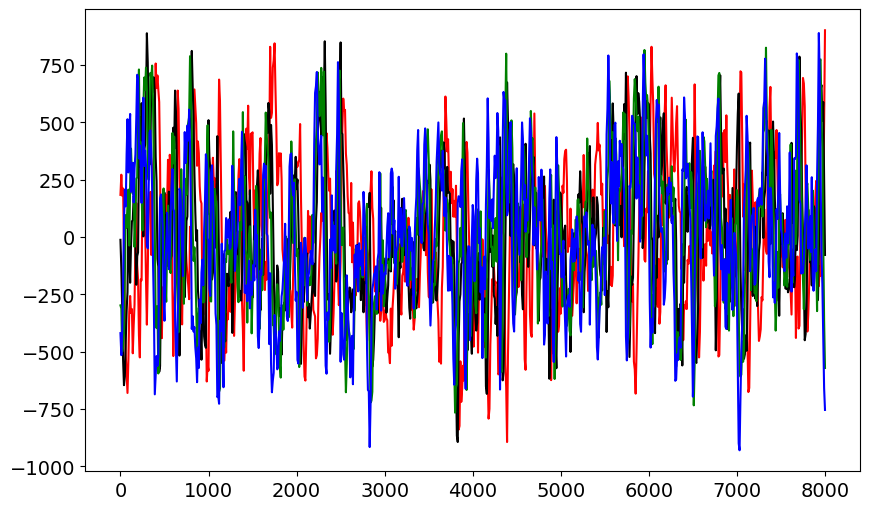

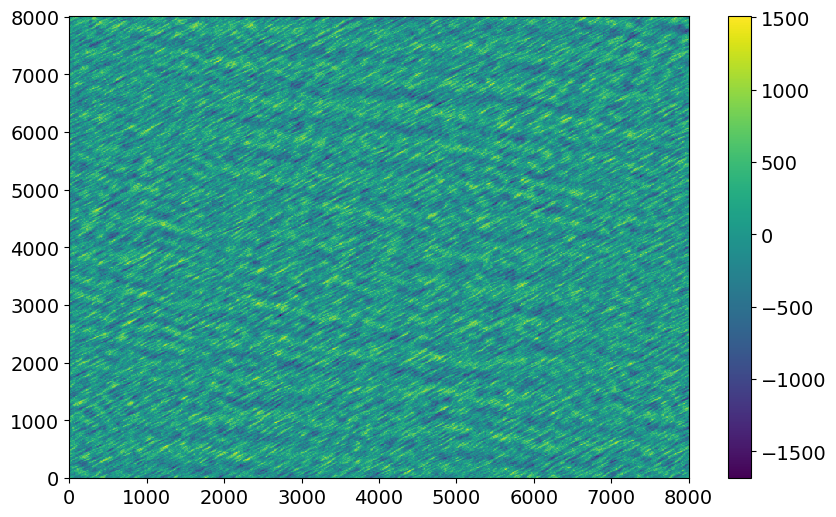

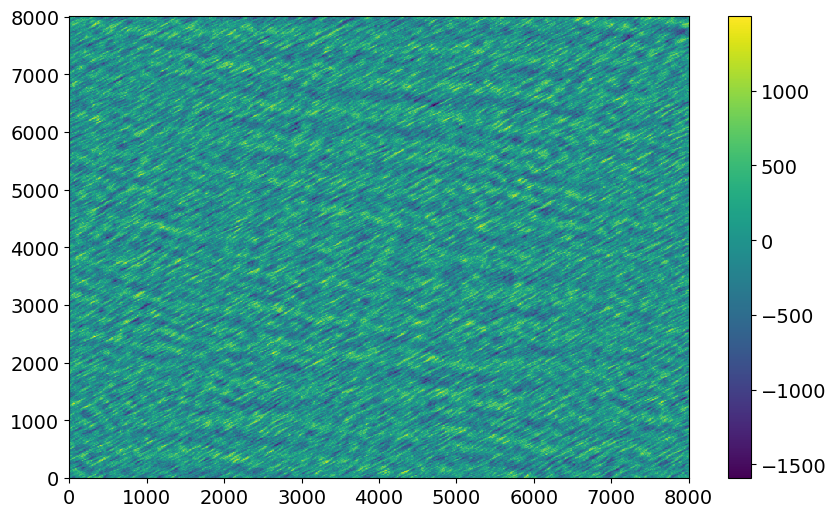

In [8]:
    plt.figure(0)
    plt.plot(x,img1[0,:],c='r')
    plt.plot(x,img2[0,:],c='k')
    plt.plot(x,img3[0,:],c='g')
    plt.plot(x,img4[0,:],c='b')

    plt.figure(1)
    plt.get_cmap('viridis')  # Utilisez 'gray' pour la carte de couleurs
    plt.title('Wave spectrum interpolated in kx,ky plane')
    plt.clf()  # Equivalent à 'clf'
    
    # Plotting convention is direction from
    # plt.pcolor(x,y, img1,vmin=0.5,vmax=3000)   #, shading='flat')
    plt.pcolor(y,x, img1)  #, shading='flat')

    plt.colorbar()  # Ajouter une barre de couleur

    plt.figure(2)
    plt.pcolor(y,x, img2)  #, shading='flat')

    plt.colorbar()  # Ajouter une barre de couleur


In [9]:
os.chdir('/home/acuevas/Bureau/S2_ALEXANDRA/OPTOOLS/PYTHON/Carte_courant/')
from spectral_analysis_functions import *
from S2_read import *
from s2_angs import *

In [10]:
os.chdir('/home/acuevas/Bureau/CDD_ifermer/')

(50, 50)
(50, 50)
(50, 50)
variance 1: 109653.70193769419 sum of spectrum: 106595.7935082157
variance 2: 109498.15084010313 sum of spectrum: 106235.95034894663


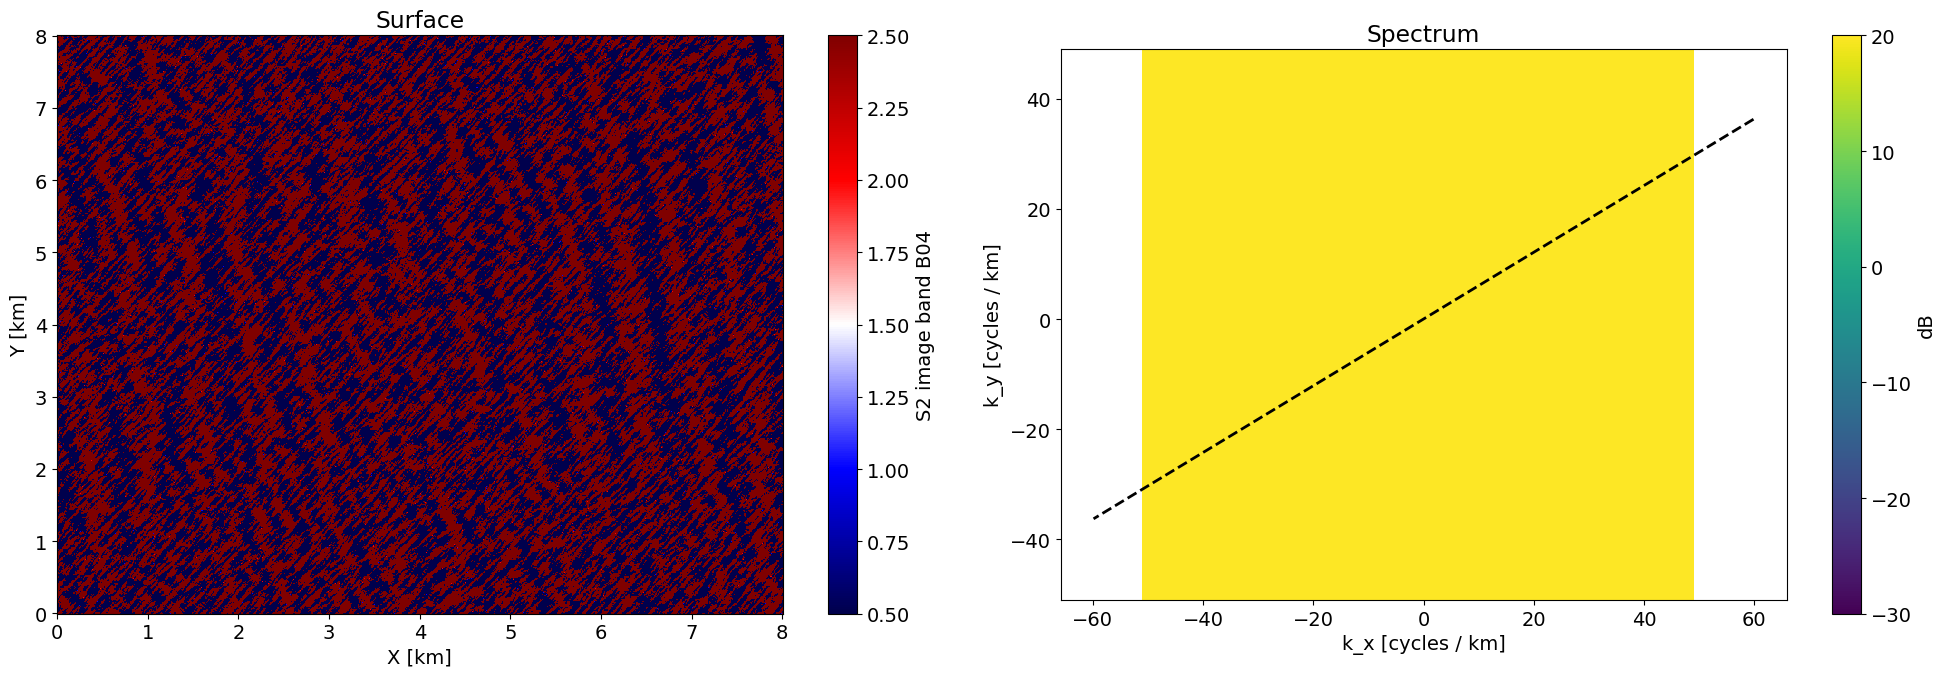

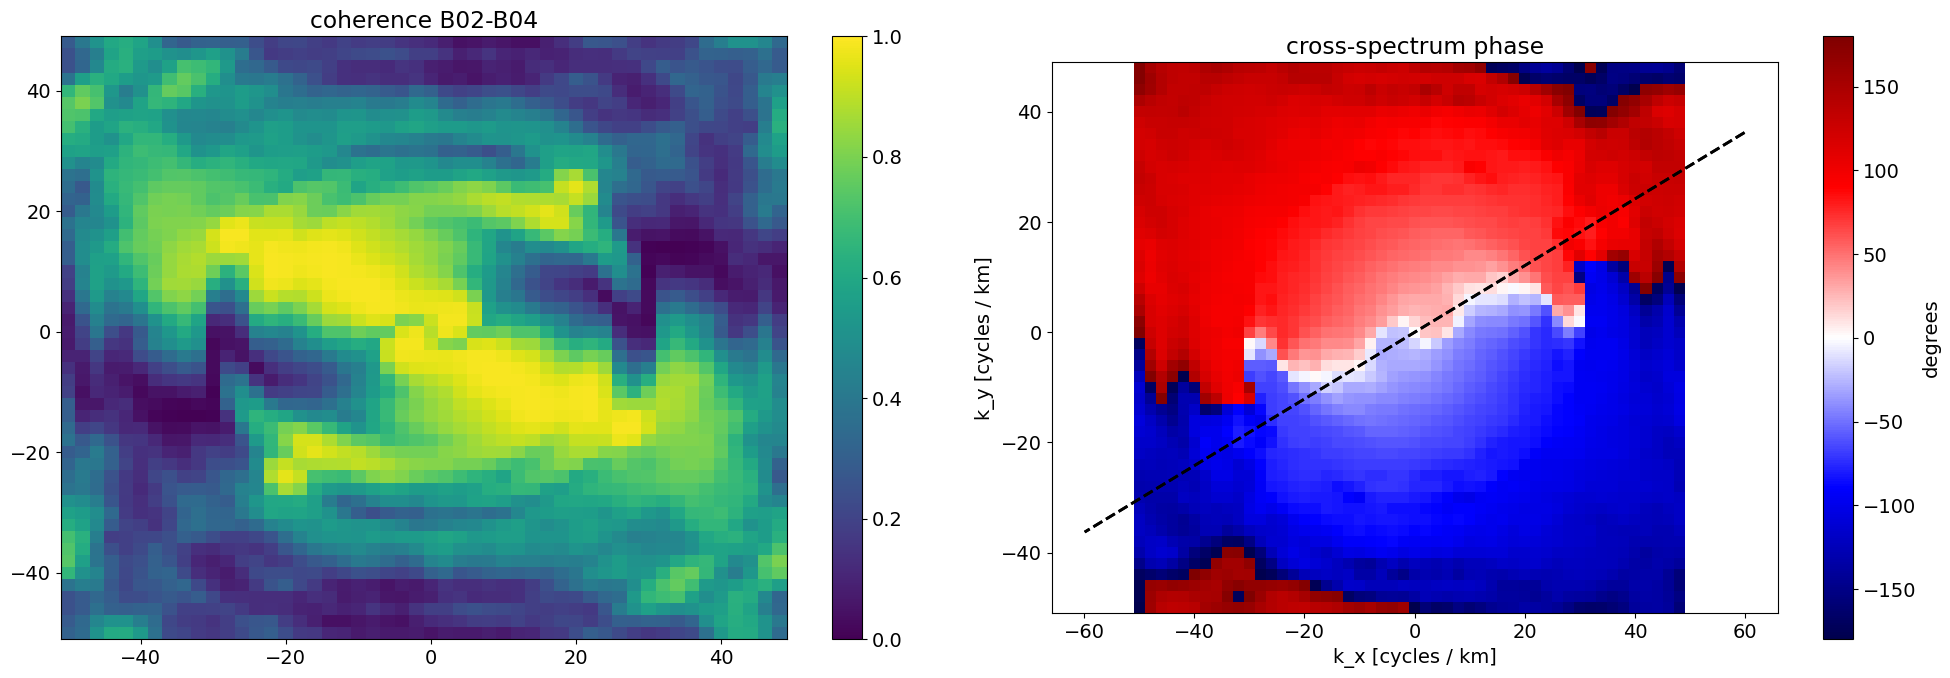

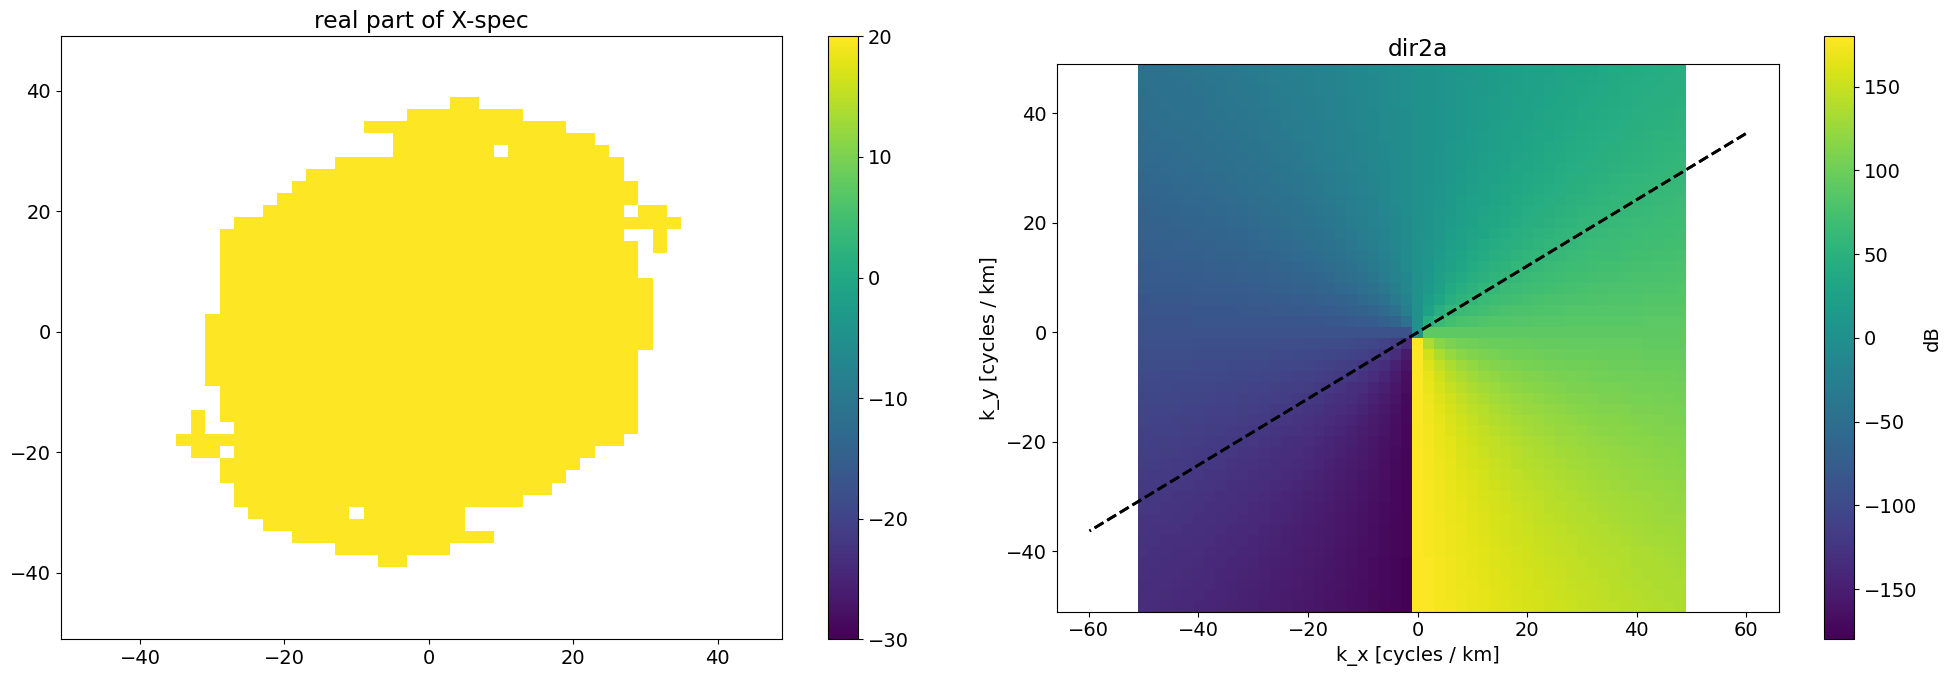

In [11]:
ntile=16
(Eta,Etb,ang,angstd,coh,crosr,phases,kx2,ky2,dkx,dky)=FFT2D_two_arrays(img2,img3,dx,dy,ntile,isplot=0)
print(np.shape(Eta))
print(np.shape(kx2))
print(np.shape(ky2))


phiblind1=phitrig[0]+90.  # blind azimuth for first band
phiblind2=phitrig[1]+90.  # blind azimuth for 3rd band
phiblind3=phitrig[2]+90.  # blind azimuth for 3rd band
kN=50
xkblind=[-1.4*kN*np.sin(np.radians(phiblind2)) , 1.4*kN*np.sin(np.radians(phiblind2))]
ykblind=[-1.4*kN*np.cos(np.radians(phiblind2)) , 1.4*kN*np.cos(np.radians(phiblind2))]


X = np.arange(0,nx*dx,dx) # from 0 to (nx-1)*dx with a dx step
Y = np.arange(0,ny*dy,dy)

fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

# warning: we use an array img1 that is written with X in the first (number 0) dimension and Y in the second
#          but pcolormesh uses the opposite order: hence the use of transpose 

im=axs[0].pcolormesh(X/1000,Y/1000,np.transpose(img2),cmap='seismic',norm = mcolors.Normalize(vmin=0.5, vmax=2.5))
_=plt.colorbar(im,ax=axs[0],label='S2 image band B04')
_=axs[0].set_xlabel('X [km]')
_=axs[0].set_ylabel('Y [km]')
_=axs[0].set_title('Surface')

im=axs[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10((Eta)),norm = mcolors.Normalize(vmin=-30, vmax=20))
_=plt.colorbar(im,ax=axs[1],label='dB')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('Spectrum')
_=plt.tight_layout()

print('variance 1:',np.var(img1.flatten()), 'sum of spectrum:',np.sum(Eta.flatten())*dkx*dky )
print('variance 2:',np.var(img4.flatten()), 'sum of spectrum:',np.sum(Etb.flatten())*dkx*dky )


fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

im=axs[0].pcolormesh(kx2*1000,ky2*1000,coh,norm = mcolors.Normalize(vmin=0, vmax=1))
_=plt.colorbar(im,ax=axs[0],label=' ')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[0].set_title('coherence B02-B04')

im=axs[1].pcolormesh(kx2*1000,ky2*1000,np.degrees(ang),cmap='seismic',norm = mcolors.Normalize(vmin=-180, vmax=180))
_=plt.colorbar(im,ax=axs[1],label='degrees')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('cross-spectrum phase')
_=plt.tight_layout()

fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

im=axs[0].pcolormesh(kx2*1000,ky2*1000,10*np.log10((crosr)),norm = mcolors.Normalize(vmin=-30, vmax=20))
_=plt.colorbar(im,ax=axs[0],label=' ')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[0].set_title('real part of X-spec')

dir2a=np.degrees(np.arctan2(kx2,ky2))
im=axs[1].pcolormesh(kx2*1000,ky2*1000,dir2a,norm = mcolors.Normalize(vmin=-180, vmax=180))
_=plt.colorbar(im,ax=axs[1],label='dB')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('dir2a')
_=plt.tight_layout()


1.0


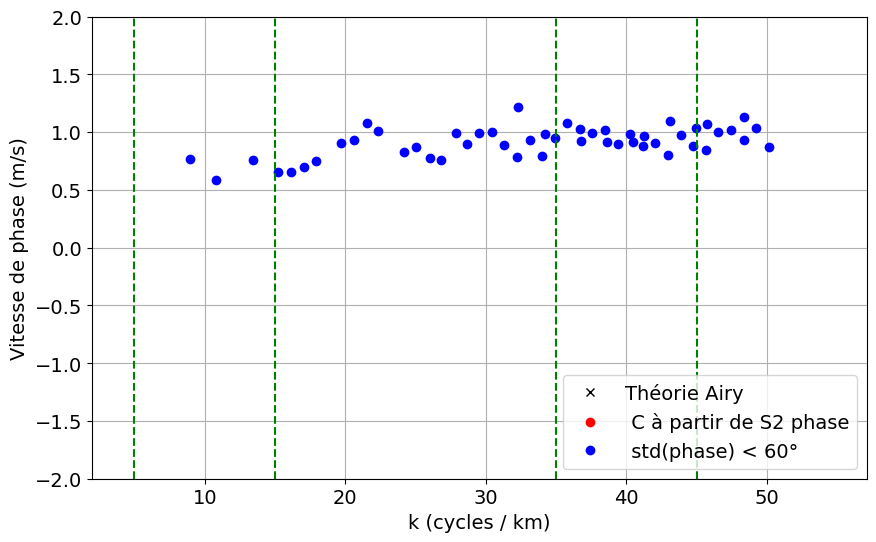

In [12]:
kn=np.sqrt(kx2**2+ky2**2)*(2*np.pi)+1E-20
kncpk=kn/(2*np.pi)*1000

# dirC1=120;dirC2=130
dirC1=110;dirC2=120
# dirC1=-70;dirC2=-60


#dt
dt=(imgtimes[2]-imgtimes[1])
print(dt)

J =np.where((coh > 0.01) & (dir2a < dirC2) & (dir2a > dirC1) & (np.degrees(angstd)  < 60) )
J2=np.where((coh > 0.01) & (dir2a < dirC2) & (dir2a > dirC1) )


dispt=np.sqrt(9.81/kn)
Cimg=ang/kn/dt
Cstd=angstd/kn/abs(dt)

#En français
plt.plot(kn[J]/(2*pi)*1000,dispt[J],'kx',linewidth=3,label='Théorie Airy') 
plt.plot(kn[J2]/(2*pi)*1000,-Cimg[J2],'ro',linewidth=1,label=' C à partir de S2 phase')
plt.plot(kn[J]/(2*pi)*1000,-Cimg[J]-dispt[J],'bo',linewidth=1,label=' std(phase) < 60°') 
# plt.plot(kn[J]/(2*pi)*1000,-Cimg[J],'bo',linewidth=1,label=' std(phase) < 60°') 


# Ajout des lignes verticales sans labels
plt.axvline(x=5, color='g', linestyle='--')
plt.axvline(x=15, color='g', linestyle='--')
plt.axvline(x=35, color='g', linestyle='--')
plt.axvline(x=45, color='g', linestyle='--')

plt.grid(True)
plt.xlabel('k (cycles / km)')
plt.ylabel('Vitesse de phase (m/s)')
plt.ylim([-2,2])
plt.legend()


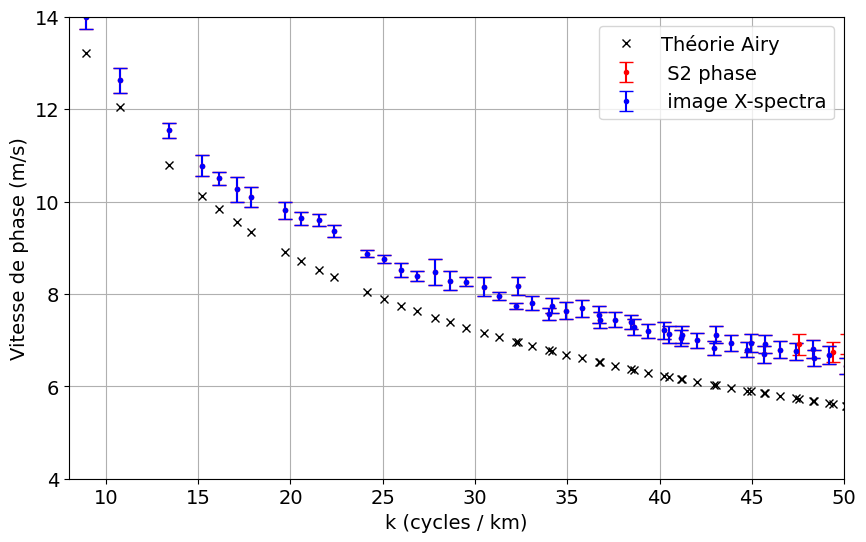

In [13]:
plt.errorbar(kn[J2]/(2*np.pi)*1000,-Cimg[J2],yerr=Cstd[J2]/16,fmt='.r',capsize=5,label=' S2 phase')
plt.errorbar(kn[J]/(2*np.pi)*1000,-Cimg[J],yerr=Cstd[J]/16,fmt='.b',capsize=5,label=' image X-spectra')
plt.plot(kn[J2]/(2*np.pi)*1000,dispt[J2],'kx',linewidth=3,label='Théorie Airy') 
plt.grid(True)
plt.axis([8,50,4,14])
plt.xlabel('k (cycles / km)')
plt.ylabel('Vitesse de phase (m/s)')
plt.legend()
plt.show()

U and V components of current : [-0.9927523  -0.03281942]
Current intensity: 0.9932946395160095
uncertainties for U and V: 0.012831148592755163 0.014865906038614828


Text(0, 0.5, '$K_y$ ')

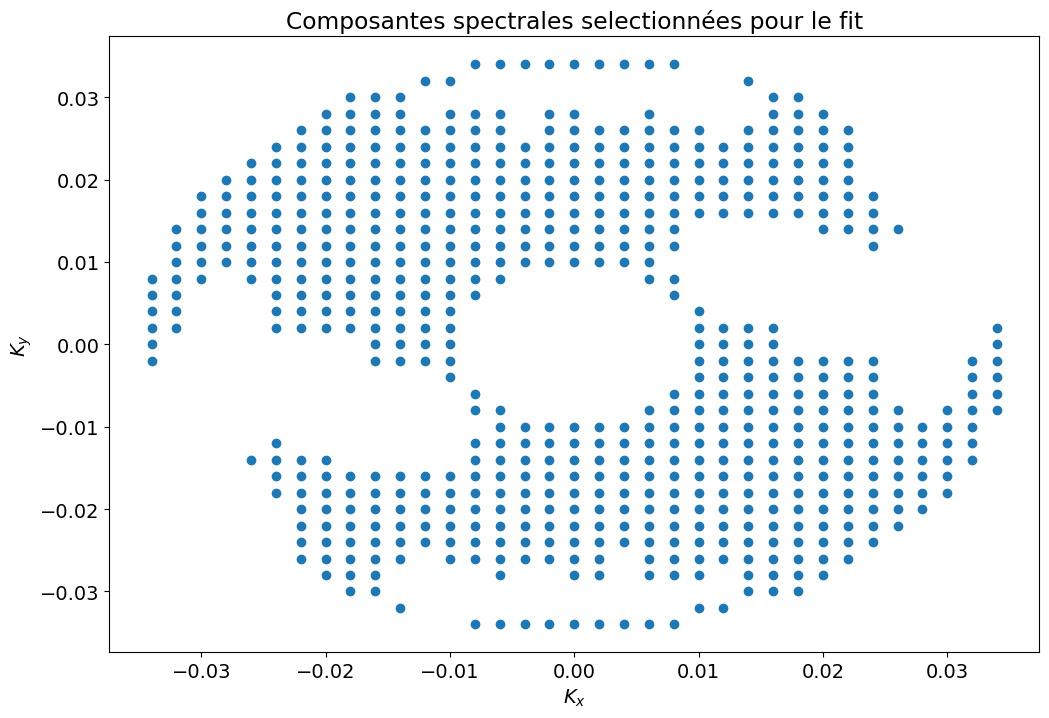

In [14]:
d2r=np.pi/180
phase_o = abs(dt) * np.sqrt(9.81 * kn)  # phase from linear theory (deep water)
phase_diff=ang-phase_o*np.sign(ang)# phase_diff should be equal to kx.Ux + ky.Uy ...
k_min_fit = 10# in cpk
k_max_fit = 35# in cpk
std_max = 60*d2r
# id_fit = np.where((angstd / d2r < std_max) & (kncpk >= k_min_fit) & (kncpk <= k_max_fit))  # & phase > 0

# id_fit = np.where((angstd.flatten()  < std_max)  & (kncpk.flatten() >= k_min_fit) & (kncpk.flatten() <= k_max_fit)&(coh.flatten()**2>0.60) )[0]  # & phase > 0
id_fit = np.where((angstd.flatten()  < std_max)  & (kncpk.flatten() >= k_min_fit) & (kncpk.flatten() <= k_max_fit))[0]  # & phase > 0
angstd=angstd.flatten()
phase_diff=phase_diff.flatten()
weight = ntile**2 / (angstd[id_fit] ** 2)/dt**2

kx1=kx2.flatten()
ky1=ky2.flatten()
K_x_fit = kx1[id_fit]
K_y_fit = ky1[id_fit]
Y2 = phase_diff[id_fit] / dt

C=np.diag(weight)
A=(np.column_stack((K_x_fit,K_y_fit)))*(2*np.pi)

# X=np.linalg.lstsq(A,Y2, rcond='warn')   
# print('U and V components of current :',X[0])
# Pondération 

ATC=np.matmul(A.T,C)
D=np.matmul(ATC,A)
#print('A:',A)
DI=np.linalg.inv(D)


X=np.matmul(DI,np.matmul(ATC,Y2))
print('U and V components of current :',X)
Cmag=np.sqrt(X[0]**2+X[1]**2)
print('Current intensity:',Cmag)

sigU=np.sqrt(abs(DI))
print('uncertainties for U and V:',sigU[0,0],sigU[1,1])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(K_x_fit, K_y_fit)
ax.set_title('Composantes spectrales selectionnées pour le fit')
ax.set_xlabel('$K_x$ ')
ax.set_ylabel('$K_y$ ')

## Test de la méthode à 3 img


In [15]:
from spectral_analysis_functions import *
from spectral_analysis_functions_3img import *
# Using OceanDataLab reader 
#from sentinel2_l1c import *
import numpy as np
from S2_read import *
from s2_angs import *

In [26]:
%run spectral_analysis_functions_3img.py

In [27]:
Umin=-5
Umax=5
ntile=16
imgtimes2=[imgtimes[0],imgtimes[1],imgtimes[2]]

In [28]:
# (E1, E2, E3, U, Uvar, Uall, EA, EB, nU, coh12, coh23, coh31, ang12, ang23, ang31, kxs, kys, angstd, phases, eps2s) = FFT2D3((img1-mean1)/std1, (img2-mean2)/std2, (img3-mean3)/std3, imgtimes, nx, ny, dx, dy, ntile, Umin, Umax)
(E1, E2, E3, U, Uvar, Uall, EA, EB, nU, coh12, coh23, coh31, ang12, ang23, ang31, kxs, kys, angstd, phases, eps2s) = FFT2D3(img1,img2,img3, imgtimes2, nx, ny, dx, dy, ntile, Umin, Umax)



nx 801 16 50
ny 801 16 50
npixel 2500
npixels 2500


In [29]:
print('shape Uall',np.shape(Uall))
print('shape U',np.shape(U))
# U=np.nanmedian(Uall[:, :, :481], axis=2)
# print(U)
print('max',np.max(U))
print('min',np.min(U))

shape Uall (50, 50, 481)
shape U (50, 50)
max 2.551803553959666
min -2.487915337417377


In [30]:
nkx=len(kxs)
nky=len(kys)

kxs2 = np.tile(kxs[:, np.newaxis], (1, nky))
kys2 = np.tile(kys[np.newaxis, :], (nkx, 1))
dir2a=np.degrees(np.arctan2(kxs2,kys2))

print(np.shape(E1))
print(np.shape(kxs))
print(np.shape(kys))
print('U med',np.shape(U))
phiblind1=phitrig[0]+90.  # blind azimuth for first band
phiblind2=phitrig[1]+90.  # blind azimuth for 3rd band
phiblind3=phitrig[2]+90.  # blind azimuth for 3rd band
kN=50
xkblind=[-1.4*kN*np.sin(np.radians(phiblind2)) , 1.4*kN*np.sin(np.radians(phiblind2))]
ykblind=[-1.4*kN*np.cos(np.radians(phiblind2)) , 1.4*kN*np.cos(np.radians(phiblind2))]

X = np.arange(0,nx*dx,dx) # from 0 to (nx-1)*dx with a dx step
Y = np.arange(0,ny*dy,dy)


(50, 50)
(50,)
(50,)
U med (50, 50)


variance 1: 109653.70193769419 sum of spectrum: 107285.93347062256
variance 2: 109482.45862705969 sum of spectrum: 106817.86807802465
variance 3: 109448.64673678268 sum of spectrum: 106457.27524550712


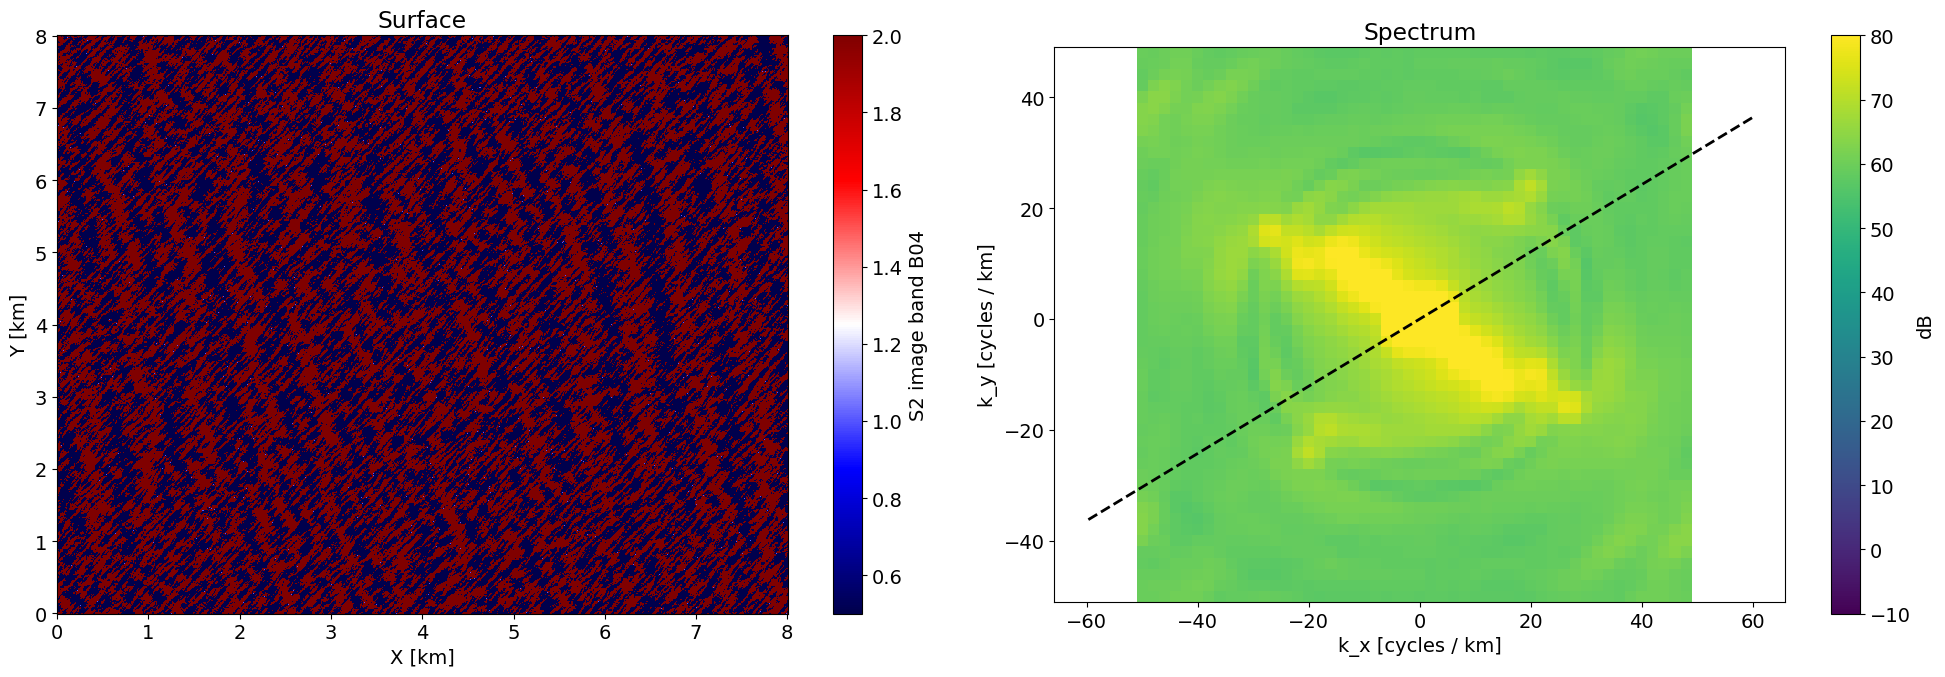

In [31]:
fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

# warning: we use an array img1 that is written with X in the first (number 0) dimension and Y in the second
#          but pcolormesh uses the opposite order: hence the use of transpose 

im=axs[0].pcolormesh(X/1000,Y/1000,np.transpose(img2),cmap='seismic',norm = mcolors.Normalize(vmin=0.5, vmax=2))
_=plt.colorbar(im,ax=axs[0],label='S2 image band B04')
_=axs[0].set_xlabel('X [km]')
_=axs[0].set_ylabel('Y [km]')
_=axs[0].set_title('Surface')

im=axs[1].pcolormesh(kxs2*1000,kys2*1000,10*np.log10((E2)),norm = mcolors.Normalize(vmin=-10, vmax=80))
_=plt.colorbar(im,ax=axs[1],label='dB')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('Spectrum')
_=plt.tight_layout()

dkx=kxs[1]-kxs[0]
dky=kys[1]-kys[0]
print('variance 1:',np.var(img1.flatten()), 'sum of spectrum:',np.sum(E1.flatten())*dkx*dky )
print('variance 2:',np.var(img2.flatten()), 'sum of spectrum:',np.sum(E2.flatten())*dkx*dky )
print('variance 3:',np.var(img3.flatten()), 'sum of spectrum:',np.sum(E3.flatten())*dkx*dky )


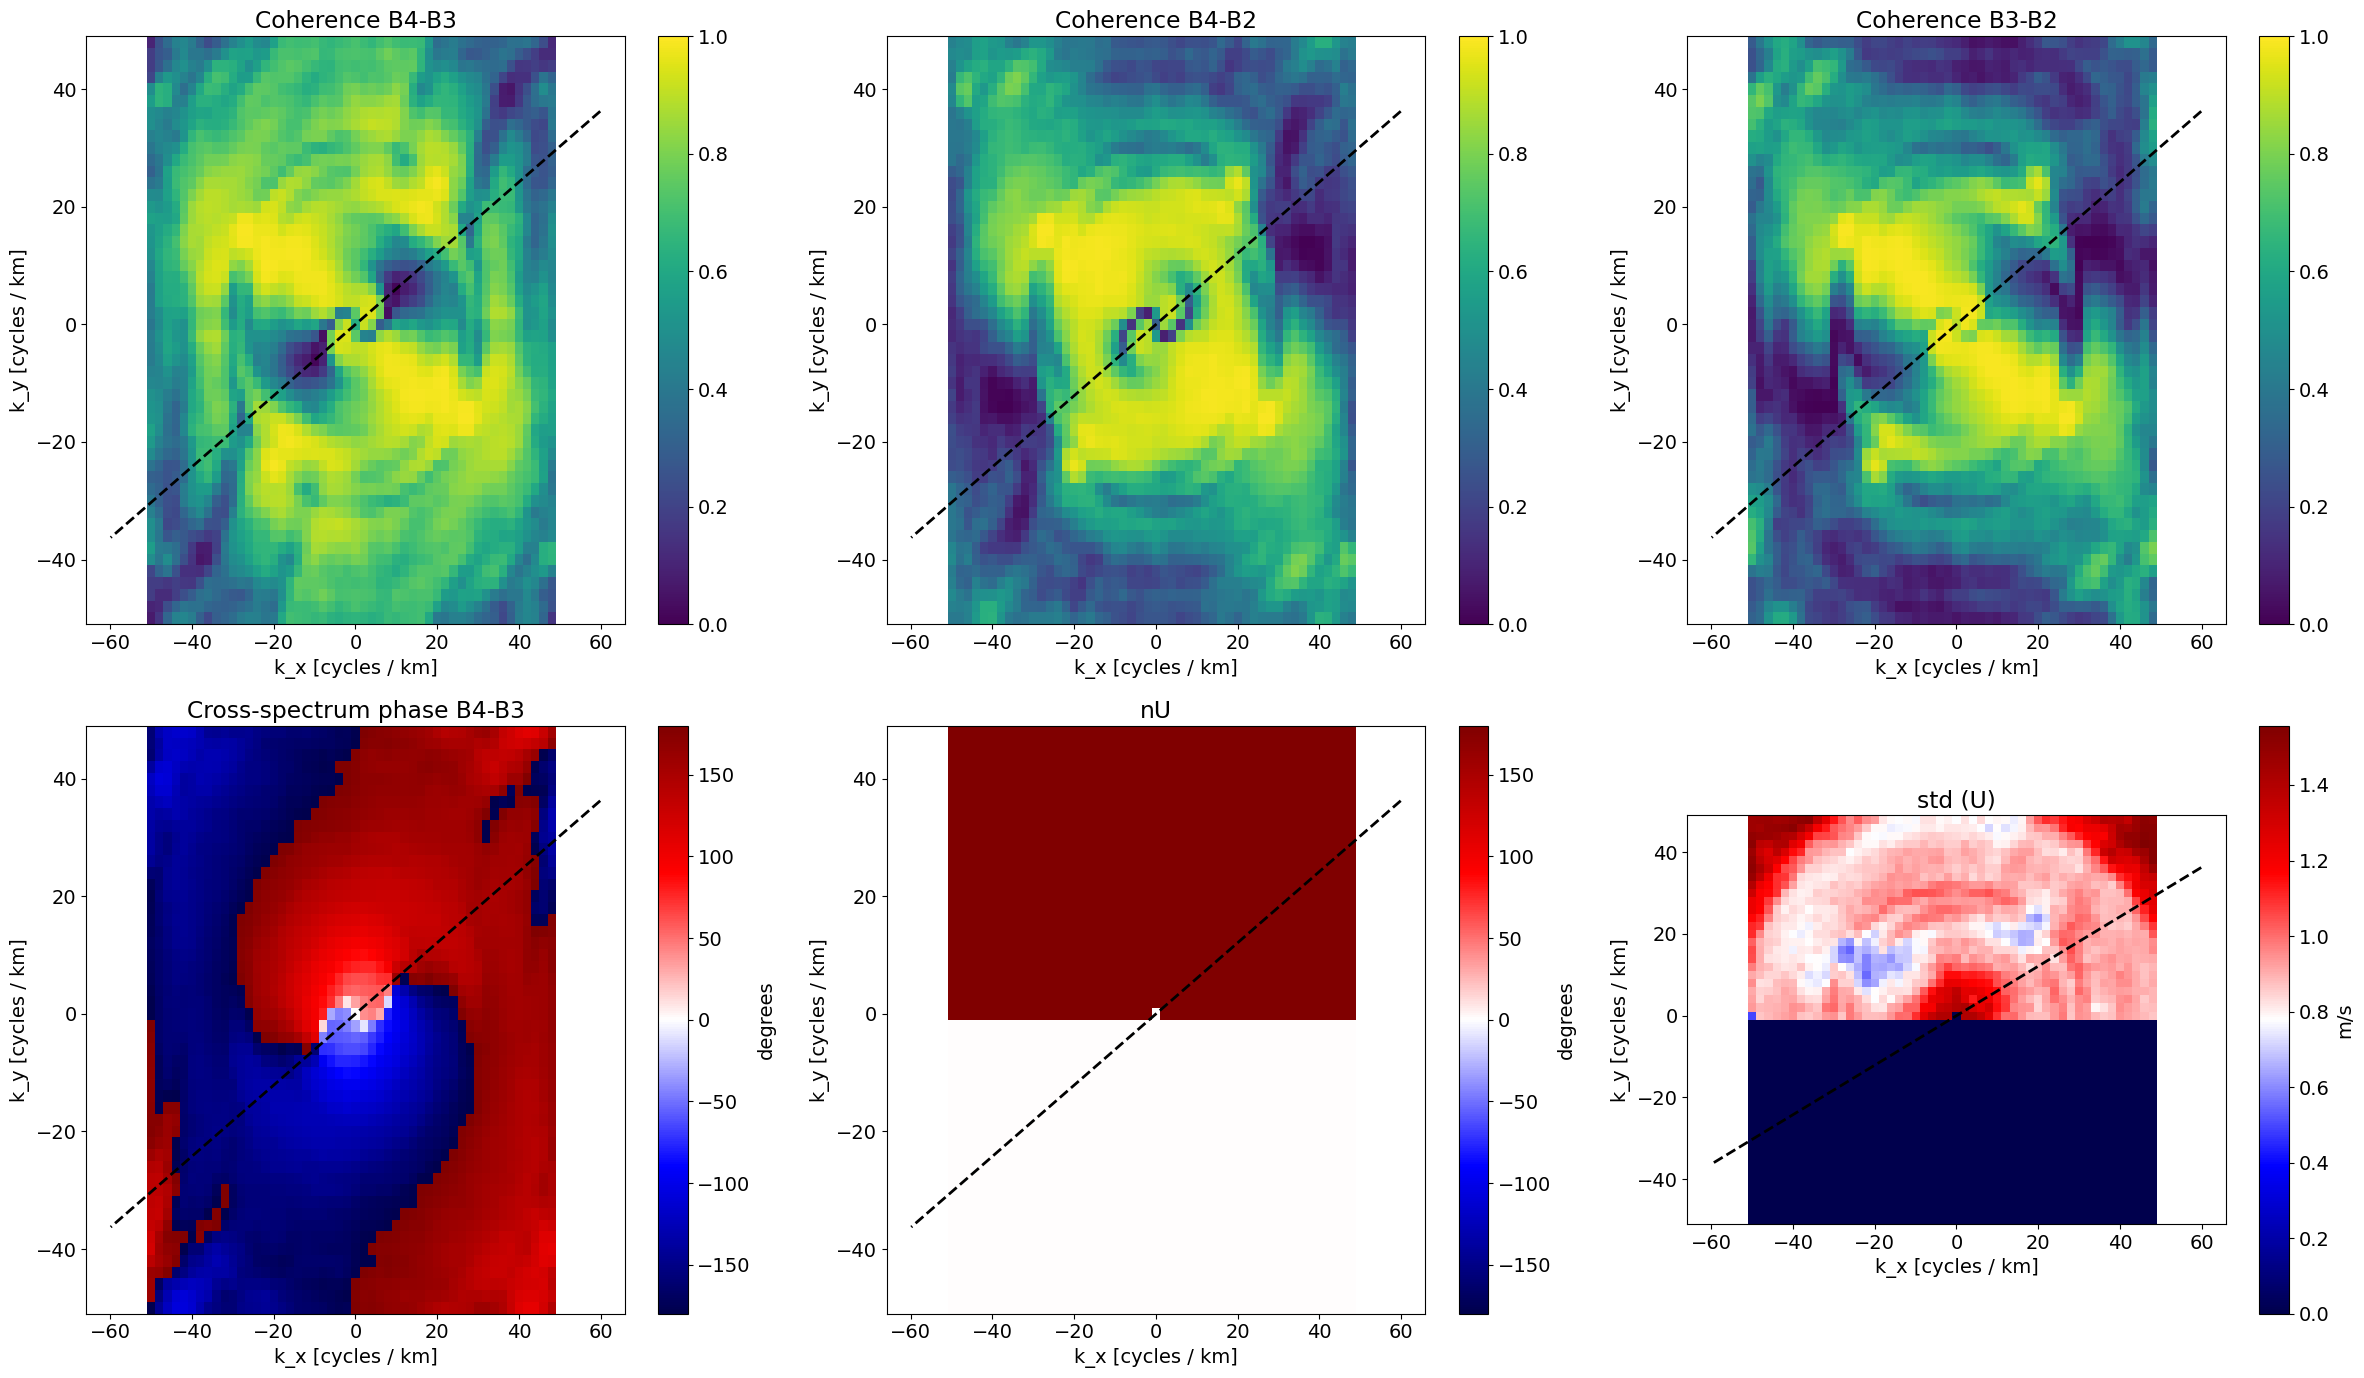

In [32]:
fig, axs = plt.subplots(2, 3, figsize=(24, 14))#,sharey=True,sharex=True)
plt.gca().set_aspect('equal', adjustable='box')

# Plot coherence between img1 and img2
im = axs[0, 0].pcolormesh(kxs2*1000, kys2*1000, coh12, norm=mcolors.Normalize(vmin=0, vmax=1))
plt.colorbar(im, ax=axs[0, 0], label=' ')
axs[0, 0].plot(xkblind, ykblind, color='k', linestyle='--', linewidth=2)
axs[0, 0].set_xlabel('k_x [cycles / km]')
axs[0, 0].set_ylabel('k_y [cycles / km]')
axs[0, 0].set_title('Coherence B4-B3')

# Plot coherence between img1 and img3
im = axs[0, 1].pcolormesh(kxs2*1000, kys2*1000, coh31, norm=mcolors.Normalize(vmin=0, vmax=1))
plt.colorbar(im, ax=axs[0, 1], label=' ')
axs[0, 1].plot(xkblind, ykblind, color='k', linestyle='--', linewidth=2)
axs[0, 1].set_xlabel('k_x [cycles / km]')
axs[0, 1].set_ylabel('k_y [cycles / km]')
axs[0, 1].set_title('Coherence B4-B2')

# Plot coherence between img2 and img3
im = axs[0, 2].pcolormesh(kxs2*1000, kys2*1000, coh23, norm=mcolors.Normalize(vmin=0, vmax=1))
plt.colorbar(im, ax=axs[0, 2], label=' ')
axs[0, 2].plot(xkblind, ykblind, color='k', linestyle='--', linewidth=2)
axs[0, 2].set_xlabel('k_x [cycles / km]')
axs[0, 2].set_ylabel('k_y [cycles / km]')
axs[0, 2].set_title('Coherence B3-B2')

# Plot phase cross-spectrum between img1 and img2
im = axs[1, 0].pcolormesh(kxs2*1000, kys2*1000, np.degrees(ang12), cmap='seismic', norm=mcolors.Normalize(vmin=-180, vmax=180))
plt.colorbar(im, ax=axs[1, 0], label='degrees')
axs[1, 0].plot(xkblind, ykblind, color='k', linestyle='--', linewidth=2)
axs[1, 0].set_xlabel('k_x [cycles / km]')
axs[1, 0].set_ylabel('k_y [cycles / km]')
axs[1, 0].set_title('Cross-spectrum phase B4-B3')

# Plot phase cross-spectrum between img1 and img3
im = axs[1, 1].pcolormesh(kxs2*1000, kys2*1000, nU, cmap='seismic', norm=mcolors.Normalize(vmin=-180, vmax=180))
plt.colorbar(im, ax=axs[1, 1], label='degrees')
axs[1, 1].plot(xkblind, ykblind, color='k', linestyle='--', linewidth=2)
axs[1, 1].set_xlabel('k_x [cycles / km]')
axs[1, 1].set_ylabel('k_y [cycles / km]')
axs[1, 1].set_title('nU')

# Plot phase cross-spectrum between img2 and img3
#im = axs[1, 2].pcolormesh(kxs2*1000, kys2*1000, np.degrees(ang23), cmap='seismic', norm=mcolors.Normalize(vmin=-180, vmax=180))
im = axs[1, 2].pcolormesh(kxs2*1000, kys2*1000, np.sqrt(Uvar), cmap='seismic')
plt.colorbar(im, ax=axs[1, 2], label='m/s')
axs[1, 2].plot(xkblind, ykblind, color='k', linestyle='--', linewidth=2)
axs[1, 2].set_xlabel('k_x [cycles / km]')
axs[1, 2].set_ylabel('k_y [cycles / km]')
axs[1, 2].set_title('std (U)')

plt.tight_layout()


In [33]:
# dirC1=110
# dirC2=120
# Je=np.where(eps2s > 0)
# ebin=eps2s*0+1
# ebin[Je]=0
# ebin2=eps2s*0
# ebin2[Je]=eps2s[Je]
# ep = np.sqrt(np.median(ebin + ebin2, axis=2))
# J4=np.where(ep >0.3)
# Up=U.copy()
# Up[J4]=np.nan
# curmax=1.5
# kxp=kxs2*1000
# kyp=kys2*1000

# plt.imshow(Up.T, extent=[kxp.min(), kxp.max(), kyp.min(), kyp.max()], aspect='equal', origin='lower')
# plt.colorbar()

# # Ajustement des limites de couleur
# plt.clim(-curmax, curmax)

# # Affichage
# plt.show()
# print(U)



NameError: name 'kxp' is not defined

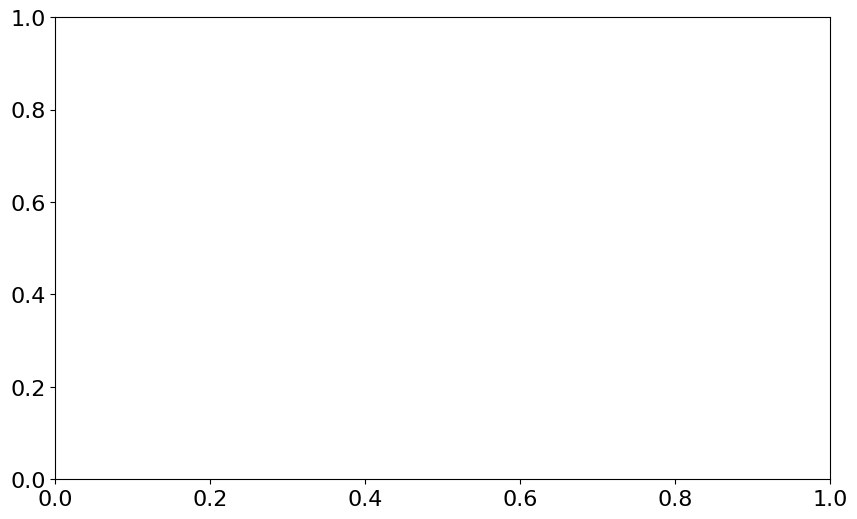

In [34]:
plt.figure(9)
plt.clf()
plt.gca().tick_params(labelsize=16)

# Calcul de l'opposition
opposition = 4 * (EA * EB) / ((EA + EB) ** 2)

# Affichage de l'image
plt.imshow(opposition, extent=[kxp.min(), kxp.max(), kyp.min(), kyp.max()], aspect='equal', origin='lower')
plt.colorbar()
plt.title(r'H(k,\phi)=4 (E(k,\phi) \times E(k,\phi+\pi))/((E(k,\phi) + E(k,\phi+\pi))^2)')
plt.clim(0, 1)
plt.axis('equal')
plt.xlim(0, kN)
plt.ylim(-kN, kN)
plt.xlabel(r'$k_x$ (cycles per km)')
plt.ylabel(r'$k_y$ (cycles per km)')

# Ajout des lignes de direction
plt.plot([0, kN * np.sin(dirC1 * d2r)], [0, kN * np.cos(dirC1 * d2r)], 'k-', linewidth=2)
plt.plot([0, kN * np.sin(dirC2 * d2r)], [0, kN * np.cos(dirC2 * d2r)], 'k-', linewidth=2)
# plt.plot([-2 * kN * np.sin(phiblind * d2r), 2 * kN * np.sin(phiblind * d2r)],
#          [-2 * kN * np.cos(phiblind * d2r), 2 * kN * np.cos(phiblind * d2r)], 'k--', linewidth=2)

# Affichage
plt.show()

" Cohérent avec Matlab ok "


In [ ]:
dirC1=110
dirC2=120 # bonds for angular sector (for making simple plot) 
curmax=1.5 # for plots
kn=np.sqrt(kxs2**2+kys2**2)*(2*np.pi)+1E-20
kncpk=kn/(2*np.pi)*1000
dt=imgtimes[2]-imgtimes[0] # Pour l'instant on fait comme ça

Je=np.where(eps2s > 0)
ebin=eps2s*0+1
ebin[Je]=0
ebin2=eps2s*0
ebin2[Je]=eps2s[Je]
ep = np.sqrt(np.median(ebin + ebin2, axis=2))
J =np.where((coh31 > 0.01) & (dir2a < dirC2) & (dir2a > dirC1) & (np.degrees(angstd)  < 60) )
J2=np.where((coh31 > 0.01) & (dir2a < dirC2) & (dir2a > dirC1) )
J3=np.where((dir2a < dirC2) & (dir2a > dirC1) & (ep<0.3))
J4=np.where(ep >0.3)
J5=np.where(coh31<0.64)
J6=np.where((dir2a < dirC2) & (dir2a > dirC1) & (np.degrees(angstd)  < 60) & (kn > (2*pi)*10/1000) & (kn < (2*pi)*40/1000))


In [ ]:
# comparison of U from 3 images and phase speed
dispt=np.sqrt(9.81/kn)
Cimg=ang31/kn/dt
Cstd=angstd/kn/abs(dt)

d2r=np.pi/180
# Calcul du courant suivant les deux composantes X et Y

UX=U*kxs2/kn
VY=U*kys2/kn

Uf=U.copy()
for ii in range(nkx):
    for jj in range(nky):
        UU=Uall[ii,jj,:]
        ee=eps2s[ii,jj,:]
        JJ=np.where(ee>-0.5)
        II=np.where((ee<0.04) & (ee>=0))
        Uf[ii,jj]=np.median(UU[II])


#En français
#plt.plot(kn[J6]/(2*pi)*1000,dispt[J6],'kx',linewidth=3,label='Théorie Airy') 
plt.plot(kn[J6]/(2*pi)*1000,Cimg[J6]-dispt[J6],'ro',linewidth=1,label='2 images')
plt.plot(kn[J6]/(2*pi)*1000,U.T[J6],'ko',linewidth=1,label='3 images')
# plt.plot(kn[J6]/(2*pi)*1000,Uf.T[J6],'ko',linewidth=1,label='3 images')
# plt.plot(kn[J]/(2*pi)*1000,Cimg[J],'bo',linewidth=1,label=' image X-spectra') 
plt.grid(True)
plt.xlabel('k (cycles / km)')
plt.ylabel('U (m/s)')
# plt.legend()


In [ ]:
Uguess=-1
Vguess=0
Clin=np.sqrt(9.81/kn)
philinp = np.mod(Clin * kn * dt + Uguess * kxs2 * dt + np.pi, 2 * np.pi) - np.pi
philinm = np.mod(-Clin * kn * dt + Uguess * kxs2 * dt + np.pi, 2 * np.pi) - np.pi
Cimg0=(ang31-philinm)/kn/dt;
Cimg2=(ang31-philinp)/kn/dt;
signchoice=np.where(abs(Cimg2) < abs(Cimg0));
Cimg0[signchoice]=Cimg2[signchoice];
Cimgp=Cimg0;
Cimgp[J5]=np.nan
Cstd=angstd/kn/abs(dt)

# Calcul du courant

CUR = (Cimgp - Clin * np.sign(ang31)).T
JJ = np.where(~np.isnan(CUR))[0]
mean_CUR = np.mean(CUR[JJ])

In [ ]:
d2r=np.pi/180
# Calcul du courant suivant les deux composantes X et Y

UX=(U*kxs2/kn)
VY=(U*kys2/kn)

# print(np.shape(UX))
# print(np.shape(VY))
avg_UX=np.average(UX)
avg_VY=np.average(VY)

med_UX=np.median(UX)
med_VY=np.median(VY)

# print('Moyenne UX',avg_UX)
# print('Moyenne VY',avg_VY)

# print('Median UX',med_UX)
# print('Median VY',med_VY)

UX_flat=UX.flatten()
VY_flat=VY.flatten()

kxs_norm=(kxs2/kn).flatten()
kys_norm=(kys2/kn).flatten()


# Moyenne sur une gamme de longueur d'onde
k_min_fit = 10 # in cpk
k_max_fit = 40 # in cpk
std_max=60*d2r
id_fit = np.where((angstd.flatten()  < std_max)  & (kncpk.flatten() >= k_min_fit) & (kncpk.flatten() <= k_max_fit) )[0]  # & phase > 0


UX_fit=UX_flat[id_fit]
VY_fit=VY_flat[id_fit]
Kx_fit=kxs_norm[id_fit]
Ky_fit=kys_norm[id_fit]
# Fonction pour calculer la moyenne en excluant les zéros
def moyenne_sans_zero(liste):
    # Filtrer les zéros
    liste_sans_zero = [x for x in liste if x != 0]
    
    # Vérifier si la liste n'est pas vide
    if not liste_sans_zero:
        return 0  # ou retourner None si vous préférez indiquer qu'il n'y a pas de moyenne

    # Calculer la moyenne
    moyenne = sum(liste_sans_zero) / len(liste_sans_zero)
    return moyenne


U_test=moyenne_sans_zero(UX_fit)

avg_Ufit=np.nanmean(UX_fit)
med_Ufit=np.nanmedian(UX_fit)
avg_Vfit=np.nanmean(VY_fit)
med_Vfit=np.nanmedian(VY_fit)

print('Moyenne UX',avg_Ufit)
print('Moyenne VY',avg_Vfit)

print('Median UX',med_Ufit)
print('Median VY',med_Vfit)

plt.plot(Kx_fit,UX_fit,'x')
plt.xlabel('kx rad/m')
plt.ylabel('U (m/s)')
print(U_test)

In [ ]:
# # Définition des indices
# # i1, j1 = 35, 22
# i1, j1 = 22, 10

# ep1 = np.squeeze(eps2s[i1, j1, :])
# II = np.where(ep1 >= 0)[0]

# plt.figure(15)
# edges = np.arange(Umin, Umax, 0.02)
# plt.hist(Uall[i1, j1, II], bins=edges)
# plt.show()



In [ ]:
# plt.figure(7)
# plt.clf()
# plt.gca().tick_params(labelsize=16)
# plt.imshow(Cimgp.T, extent=[kxs.min()/(2*np.pi)*1000, kxs.max()/(2*np.pi)*1000, 
#                             kys.min()/(2*np.pi)*1000, kys.max()/(2*np.pi)*1000],
#            aspect='equal', cmap=plt.cm.viridis, origin='lower')
# plt.colorbar()
# plt.clim(-curmax, curmax)


# plt.axis('equal')
# plt.tick_params(labelsize=16)
# plt.xlabel('k_x (cycles per km)')
# plt.ylabel('k_y (cycles per km)')

# plt.title('Courant pour 2 images')
# plt.show()

# plt.figure(8)
# plt.clf()
# plt.gca().tick_params(labelsize=16)

# # Affichage de l'image avec les axes correctement étiquetés et l'aspect égal
# plt.pcolormesh(kxs2*1000, kys2*1000, U, norm=mcolors.Normalize(vmin=-curmax, vmax=curmax))
# plt.colorbar()
# plt.clim(-curmax, curmax)

# # Définir les limites de l'axe des abscisses pour ne montrer que la moitié positive
# #plt.xlim(0, kxs.max()/(2*np.pi)*1000)

# plt.xlabel(r'$k_x$ (cycles per km)')
# plt.ylabel(r'$k_y$ (cycles per km)')

# plt.show()



In [ ]:
#  #Préparation des données
# Up = np.copy(U)
# Up[J4] = np.nan  # Remplacement par NaN

# print('U shape:', np.shape(U))
# print('Up shape:', np.shape(Up))
# print('J4 shape:', np.shape(J4))

# # Vérifiez les indices et les valeurs NaN
# # print('Indices in J4 (sample):', J4[:10])
# # print('NaNs in Up:', np.isnan(Up).sum())
# # print('Min and Max values in Up:', np.nanmin(Up), np.nanmax(Up))
# # print('kxs range:', kxs.min(), kxs.max())
# # print('kys range:', kys.min(), kys.max())

# # Trouver les indices des éléments non-NaN
# not_nan_indices = np.argwhere(~np.isnan(Up))
# print("Sample indices of non-NaN values:", not_nan_indices[:10])


# # Création de la figure
# plt.figure(figsize=(8, 6))
# plt.gca().set_aspect('equal', adjustable='box')
# plt.gca().set_facecolor('white')

# # Normalisation et affichage de l'image
# norm = Normalize(vmin=np.nanmin(Up), vmax=np.nanmax(Up))
# plt.imshow(Up.T, extent=[kxs2.min()/(2*np.pi)*1000, kxs2.max()/(2*np.pi)*1000, 
#                             kys2.min()/(2*np.pi)*1000, kys2.max()/(2*np.pi)*1000],
#            aspect='equal', cmap=plt.cm.viridis, origin='lower')
# plt.colorbar(label='Intensity')

# # Configuration des axes
# plt.xlabel('k_x (cycles / km)')
# plt.ylabel('k_y (cycles / km)')
# plt.title('Courrant  3 img. LS')

# # Affichage
# plt.show()
